# Cicero's Hardest Sentence?: Measuring Readability in Latin Literature

An iPython notebook to demonstrate the use of the Classical Language Toolkit for a preliminary investagation of readability measurements for Latin literature.

Project arose from a conversation with Latin & Greek teachers this summer about how much reading to assign to their intermediate students per class. Each teacher had a different suggestion of how many "lines per class" their students could "handle", and varying perspectives on how "hard" different authors/work were, how long it would take their students to complete assignments, etc. Each teacher brought to the conversation years, even decades of teaching experience to support their arguments for more or less material to assign. Such qualitative expertise cannot be discounted. At the same time, I happened to be working on natural language processing tool development for the Classical Language Toolkit at the time and became interested in ways in which the formal measurements (word length, sentence length, lexical diversity, etc.) made available by the CLTK could help teachers develop a quanititative basis on which to make decisions about assignments. I began to look into the subject of "readability" and work in English and decided to start evaluating these kinds of methods for classical languages.

So the long-term goals of this project are:
    1. to develop objective measurements for comparing different Latin authors, works, parts of works, etc.
    2. to use comparative measurements to allow students to be matched with reading material at an appropriate level, but especially to help emergent readers move from textbooks to reading Latin texts with the least amount of difficulty

## Imports

In [1]:
import os
import re
import csv
import string

from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

from cltk.corpus.latin import latinlibrary
from cltk.tokenize.sentence import TokenizeSentence
from cltk.tokenize.word import WordTokenizer
from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
from cltk.stem.latin.j_v import JVReplacer
from cltk.utils.file_operations import open_pickle

## Data

For this study, I am using the works of Cicero as found on the site **The Latin Library** (thelatinlibrary.com). The Latin Library is available from the CLTK as a plaintext corpus. Since it is freely and easily available in this format, it is an ideal choice for a preliminary investigation of these words.

The corpus can be loaded into Python (assuming the current version of CLTK is installed) with the following command:

In [2]:
from cltk.corpus.latin import latinlibrary

### Process Files

In [3]:
files = latinlibrary.fileids()
print(len(files))
print(files[:10])

2162
['12tables.txt', '1644.txt', 'abbofloracensis.txt', 'abelard/dialogus.txt', 'abelard/epistola.txt', 'abelard/historia.txt', 'addison/barometri.txt', 'addison/burnett.txt', 'addison/hannes.txt', 'addison/machinae.txt']


We need to extract only the files we need, specifically the works of Cicero, from the 2,162 files that are in the Latin Library corpus.

In [4]:
print(files[498:508])

['cicero/acad.txt', 'cicero/adbrutum1.txt', 'cicero/adbrutum2.txt', 'cicero/amic.txt', 'cicero/arch.txt', 'cicero/att1.txt', 'cicero/att10.txt', 'cicero/att11.txt', 'cicero/att12.txt', 'cicero/att13.txt']


As we see in the cell above, we can get these files by matching on the directory 'cicero/'. (Note that there are three 'top-level' files that need to be excluded from the files we want to work with.)

In [5]:
cicero_files = [file for file in files if 'cicero/' in file]

excluded_files = ['cicero/consulatu.txt', 'cicero/divinatione.txt', 'cicero/nd.txt']
cicero_files = [file for file in cicero_files if file not in excluded_files]

print(len(cicero_files))
print(cicero_files[:10])

137
['cicero/acad.txt', 'cicero/adbrutum1.txt', 'cicero/adbrutum2.txt', 'cicero/amic.txt', 'cicero/arch.txt', 'cicero/att1.txt', 'cicero/att10.txt', 'cicero/att11.txt', 'cicero/att12.txt', 'cicero/att13.txt']


So, our data consists of 137 plaintext files of the works of cicero.

Here is an idea of what the files look like when we load them:

In [6]:
print(latinlibrary.raw('cicero/acad.txt')[:1000])

Cicero: Academica
		 

		 
		 
	 
	
 

 M. TVLLI CICERONIS ACADEMICI LIBRI QVATTVOR
 

 
 
Liber primus: [1] 
 [2] 
 [3] 
 [4] 
 [5] 
 [6] 
 [7] 
 [8] 
 [9] 
 [10] 
 [11] 
 [12] 
 Liber secundus 
 Liber tertius 
 
 

 
 [1] In Cumano nuper cum mecum Atticus noster esset, nuntiatum est nobis a M. Varrone venisse eum Roma pridie vesperi et, nisi de via fessus esset, continuo ad nos venturum fuisse. quod cum audissemus, nullam moram interponendam putavimus quin videremus hominem nobiscum et studiis eisdem et vetustate amicitiae coniunctum; itaque confestim ad eum ire perreximus. paulumque cum ab eius villa abessemus, ipsum ad nos venientem vidimus; atque illum complexi, ut mos amicorum est (satis enim longo inter vallo **), ad suam villam reduximus. 
 

 
hic pauca primo atque ea percunctantibus nobis ecquid forte Roma novi. &lt;Tum&gt; Atticus 'Omitte ista quae nec percunctari nec audire sine molestia possumus quaeso' inquit 'et quaere potius ecquid ipse novi. silent enim diutius Musae V

We need to preprocess these texts before we can do meaningful work with them. For this we will use a combination of built-in Python methods and modules designed specifically for Latin found in the CLTK.

The first thing we will do is make a list of the unprocessed texts, i.e. a list of *very* long strings, each a work of Cicero found in the Latin Library.

In [7]:
cicero_texts = [latinlibrary.raw(file) for file in cicero_files]

print(len(cicero_texts))

137


And let's keep things orderly by keeping a list of titles. Since the first line of every LL page contains the work's title, we can iterate over our texts and capture this information.

In [8]:
cicero_titles = [text.split('\n')[0].strip() for text in cicero_texts] #Take only the first line
cicero_titles = [title.lower().strip() for title in cicero_titles] #Adjust for inconsistancies in case; trim spaces
cicero_titles = [title[:-1] if title.endswith('.') else title for title in cicero_titles] #Remove trailing punct.

print(len(cicero_titles))
print(cicero_titles)

137
['cicero: academica', 'cicero: ad brutum i', 'cicero: ad brutum ii', 'cicero: de amicitia', 'cicero: pro archia', 'cicero: ad atticum i', 'cicero: ad atticum x', 'cicero: ad atticum xi', 'cicero: ad atticum xii', 'cicero: ad atticum xiii', 'cicero: ad atticum xiv', 'cicero: ad atticum xv', 'cicero: ad atticum xvi', 'cicero: ad atticum ii', 'cicero: ad atticum iii', 'cicero: ad atticum iv', 'cicero: ad atticum v', 'cicero: ad atticum vi', 'cicero: ad atticum vii', 'cicero: ad atticum viii', 'cicero: ad atticum ix', 'pro l. cornelio balbo oratio', 'brutus', 'in caecilium oratio', 'pro a. caecina oratio', 'pro m. caelio oratio', 'cicero: in catilinam i', 'cicero: in catilinam ii', 'cicero: in catilinam iii', 'cicero: in catilinam iv', 'pro a. clventio oratio', 'commentariolvm petitionis', 'pro rege deiotaro', 'de divinatione liber prior', 'de divinatione liber alter', 'de domo sva', 'cicero: ad familiares i', 'cicero: ad familiares x', 'cicero: ad familiares xi', 'cicero: ad familiare

### NLP Workflow

(Load corpus) > Preprocess > Tokenize > Stem, Lemmatize, POS-Tag, etc. > Process

### Function for preprocessing texts

In [9]:
# Preprocess texts
def preprocess(text):    
    
    text = text.lower()
    
    text= re.sub(r'&lt;','<',text)
    text= re.sub(r'&gt;','>',text)    
        
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)

    remove_list = [r'\bthe latin library\b', r'\bthe classics page\b', r'\bcicero\s+?$'] 
    for pattern in remove_list:
        text = re.sub(pattern, '', text)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text

### Preprocess Texts

In [10]:
cicero_texts = [preprocess(text) for text in cicero_texts]

print('\nBEFORE: \n ----------')
print(latinlibrary.raw('cicero/acad.txt')[:1000])

print('\nAfter: \n ----------')
print(cicero_texts[0][:1000])


BEFORE: 
 ----------
Cicero: Academica
		 

		 
		 
	 
	
 

 M. TVLLI CICERONIS ACADEMICI LIBRI QVATTVOR
 

 
 
Liber primus: [1] 
 [2] 
 [3] 
 [4] 
 [5] 
 [6] 
 [7] 
 [8] 
 [9] 
 [10] 
 [11] 
 [12] 
 Liber secundus 
 Liber tertius 
 
 

 
 [1] In Cumano nuper cum mecum Atticus noster esset, nuntiatum est nobis a M. Varrone venisse eum Roma pridie vesperi et, nisi de via fessus esset, continuo ad nos venturum fuisse. quod cum audissemus, nullam moram interponendam putavimus quin videremus hominem nobiscum et studiis eisdem et vetustate amicitiae coniunctum; itaque confestim ad eum ire perreximus. paulumque cum ab eius villa abessemus, ipsum ad nos venientem vidimus; atque illum complexi, ut mos amicorum est (satis enim longo inter vallo **), ad suam villam reduximus. 
 

 
hic pauca primo atque ea percunctantibus nobis ecquid forte Roma novi. &lt;Tum&gt; Atticus 'Omitte ista quae nec percunctari nec audire sine molestia possumus quaeso' inquit 'et quaere potius ecquid ipse novi. silen

We now have a list of preprocessed text files which we can use for our readability measurements.

## Classic Readability

Classic readability refers to the measurement of relative ease and difficult of reading material through two main measurements:

- Sentence length (primarily measured in number of words)
- Lexical difficulty

Dale Chall (1949, 1) defined the "success" of reading any given passage as the "extent to which [readers] understand it, read it at an optimal speed, and find it interesting." The first stage of my research on readability will deal with only the first, and to a lesser degree the second, of these criteria.

Much work has been done on lexical difficulty and diversity in classics. [list/summarize important articles]

Less attention has been paid to formal features such as word/sentence length, character/syllable counts, etc. That said, it has always been implicitly 

Note: So-called "classic" readability can be distinguished from 

#### Pedagogical value of sentence length for Latin
##### "Sentences of two words"

<img src="img/two_words.jpg">

#### Pedagogical value of sentence length for Latin
##### "Sententiae plurium dictionum", i.e. "sentences of more words"

<img src="img/more_words.jpg">

from Hoole's 1658 *Sententiae pueriles anglo-latinae*
https://books.google.com/books?id=i_9mAAAAcAAJ

The idea that shorter sentences are easier for emergent readers to learn may appear self-evident, and, even in Latin pedagogy, the early placement in the curriculum of the Monostichs / Distichs of Cato, the sententiae of Publilius Syrus, and similar material, confirms this. The modern equivalent can be seen in the average length of sentences in Chapter 1 of Wheelock versus Chapter 40. At the same time, sentence length is variable and it still remains a valid question to ask—how many words are in a short sentence? and by extension, how many words can be in a sentence before it becomes difficult to read?

## CLTK Tools

In [11]:
# Set up training sentences

rel_path = os.path.join('~/cltk_data/latin/model/latin_models_cltk/lemmata/backoff')
path = os.path.expanduser(rel_path)

# Check for presence of latin_pos_lemmatized_sents
file = 'latin_pos_lemmatized_sents.pickle'      

latin_pos_lemmatized_sents_path = os.path.join(path, file)
if os.path.isfile(latin_pos_lemmatized_sents_path):
    latin_pos_lemmatized_sents = open_pickle(latin_pos_lemmatized_sents_path)
else:
    latin_pos_lemmatized_sents = []
    print('The file %s is not available in cltk_data' % file)  

In [12]:
word_tokenizer = WordTokenizer('latin')
sent_tokenizer = TokenizeSentence('latin')
lemmatizer = BackoffLatinLemmatizer(latin_pos_lemmatized_sents)
replacer = JVReplacer()

In [13]:
def sent_count(text):
    sents = sent_tokenizer.tokenize(text)
    return(len(sents))

def word_count(text):
    words = word_tokenizer.tokenize(text)
    return(len(words))

def char_count(text):
    return len(text)

def syll_count(text):
    return sum(letter in 'aeiouy' for letter in text.lower())

def comp_word_count(text):
    words = text.split()
    comp_words = [word for word in words if syll_count(word) > 3]
    return len(comp_words)



In [14]:
def ari(text):
    c, w, s = char_count(text), word_count(text), sent_count(text)
    score = 4.71 * (c / w) + 0.5 * (w / s) - 21.43
    return score

In [15]:
def gunningfog(text):
    w, s, cw = word_count(text), sent_count(text), comp_word_count(text)
    score = 0.4 * ((w / s) + (100 * (cw / w)))
    return score

In [16]:
def fleschkincaid(text):
    w, s, sy = word_count(text), sent_count(text), syll_count(text)
    score = (0.39 * (w / s)) + (11.8 * (sy / w)) - 15.59
    return score

In [17]:
def coleman_liau(text):
    c, w, s = char_count(text), word_count(text), sent_count(text)
    cs, ss = (c / w) * 100, (s / w) * 100
    score = (0.0588 * cs) - (0.296 * ss) - 15.8
    return score

In [18]:
# Remove paragraphs less than 10 words long
cicero_paras = []

for text in cicero_texts:
    paras = text.split('\n')
    paras = [" ".join(para.split()) for para in paras]
    
    paras = [para for para in paras if len(para.split()) > 10]
    cicero_paras.append(paras)

In [19]:
aris = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    aris.append((cicero_titles[i],ari(text)))
    
           
aris.sort(key=lambda x: x[1])
pprint(aris[:5])               
pprint(aris[-5:])

[('cicero: ad atticum xiii', 8.518604266068955),
 ('cicero: ad atticum xii', 8.926175247389793),
 ('cicero: ad atticum xv', 9.316047349881217),
 ('cicero: ad familiares xiv', 10.036480750927304),
 ('cicero: ad atticum xvi', 10.302402547994994)]
[('cicero: de oratore iii', 26.79574810281249),
 ('cicero: de oratore ii', 27.304608303143894),
 ('cicero: post reditum ad quirites', 27.545054641341288),
 ('cicero: ad familiares i', 29.054788968318682),
 ('cicero: de oratore i', 31.029355209322325)]


In [20]:
cls = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    cls.append((cicero_titles[i],coleman_liau(text)))
    
           
cls.sort(key=lambda x: x[1])
pprint(cls[:5])               
pprint(cls[-5:])

[('cicero: ad atticum xiii', 12.441305222640182),
 ('cicero: ad atticum xii', 12.765881164477918),
 ('cicero: ad atticum xv', 13.234013271073973),
 ('cicero: ad familiares xiv', 13.869518455145446),
 ('cicero: ad atticum xvi', 14.132220566318928)]
[('cicero: in catilinam iv', 21.36215293731539),
 ('cicero: post reditum in senatu', 21.681293729372936),
 ('cicero: philippic xiv', 22.016496674057645),
 ('cicero: post reditum ad quirites', 22.117553384002893),
 ('cicero: de re publica iv', 22.825120772946857)]


In [21]:
fks = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    fks.append((cicero_titles[i],fleschkincaid(text)))
    
           
fks.sort(key=lambda x: x[1])
pprint(fks[:5])               
pprint(fks[-5:])

[('cicero: ad atticum xiii', 11.397322175228652),
 ('cicero: ad atticum xii', 11.936971087306954),
 ('cicero: ad atticum xv', 12.34724772671418),
 ('cicero: ad familiares xiv', 12.749659923391352),
 ('cicero: ad atticum xvi', 13.385129129015834)]
[('cicero: de oratore iii', 27.73675182259611),
 ('cicero: de oratore ii', 28.119757955764054),
 ('cicero: post reditum ad quirites', 28.457473854411962),
 ('cicero: ad familiares i', 29.333325668610787),
 ('cicero: de oratore i', 31.296026477510555)]


In [22]:
gfs = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    gfs.append((cicero_titles[i],gunningfog(text)))
    
           
gfs.sort(key=lambda x: x[1])
pprint(gfs[:5])               
pprint(gfs[-5:])

[('cicero: ad atticum xiii', 9.127952085762171),
 ('cicero: ad atticum xii', 9.438213409409675),
 ('cicero: ad atticum xv', 9.93396248054395),
 ('cicero: ad atticum xi', 10.253558538387052),
 ('cicero: ad familiares xiv', 10.57960845798946)]
[('cicero: de oratore iii', 23.103391605328667),
 ('cicero: de oratore ii', 23.588741384446013),
 ('cicero: post reditum ad quirites', 24.284480919008608),
 ('cicero: ad familiares i', 25.341200608762485),
 ('cicero: de oratore i', 26.611089173241858)]


In [23]:
# Length of work
lengths = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    tokens = word_tokenizer.tokenize(text)
    lengths.append((cicero_titles[i], len(tokens)))

lengths.sort(key=lambda x: x[1])
pprint(lengths[:5])
pprint(lengths[-5:])

[('cicero: de re publica iv', 207),
 ('cicero: de re publica v', 391),
 ('cicero: de lege agraria iii', 1346),
 ('cicero: philippic iv', 1462),
 ('cicero: de optimo genere oratorum', 1665)]
[('cicero: in verrem ii.5', 20326),
 ('pro a. clventio oratio', 22366),
 ('brutus', 26335),
 ('cicero: in verrem ii.3', 26540),
 ('cicero: de oratore ii', 28132)]


In [24]:
# Unique words
uniques = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    tokens = word_tokenizer.tokenize(text)
    uniques.append((cicero_titles[i], len(set(tokens))))

uniques.sort(key=lambda x: x[1])
pprint(uniques[:5])
pprint(uniques[-5:])

[('cicero: de re publica iv', 170),
 ('cicero: de re publica v', 280),
 ('cicero: de lege agraria iii', 714),
 ('cicero: philippic iv', 764),
 ('cicero: de optimo genere oratorum', 817)]
[('pro a. clventio oratio', 5671),
 ('cicero: in verrem ii.5', 5705),
 ('cicero: in verrem ii.3', 6320),
 ('brutus', 6647),
 ('cicero: de oratore ii', 7046)]


In [25]:
# Lexical diversity
lexdivs = []
lexdivs_tokens = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    tokens = word_tokenizer.tokenize(text)
    lexdivs_tokens.append(tokens)
    lexdivs.append((cicero_titles[i], len(set(tokens)) / len(tokens)))

lexdivs.sort(key=lambda x: x[1])
pprint(lexdivs[:5])
pprint(lexdivs[-5:])

[('cicero: de inventione ii', 0.22602104803969683),
 ('cicero: ad familiares xiii', 0.2324374954967937),
 ('cicero: in verrem ii.3', 0.23813112283345894),
 ('cicero: de inventione i', 0.23917388407728182),
 ('cicero: de oratore ii', 0.25046210720887246)]
[('cicero: philippic ix', 0.5074370709382151),
 ('cicero: philippic iv', 0.5225718194254446),
 ('cicero: de lege agraria iii', 0.5304606240713224),
 ('cicero: de re publica v', 0.7161125319693095),
 ('cicero: de re publica iv', 0.821256038647343)]


Min:  0.22602104803969683
Mean:  0.367160245573
Max:  0.821256038647343


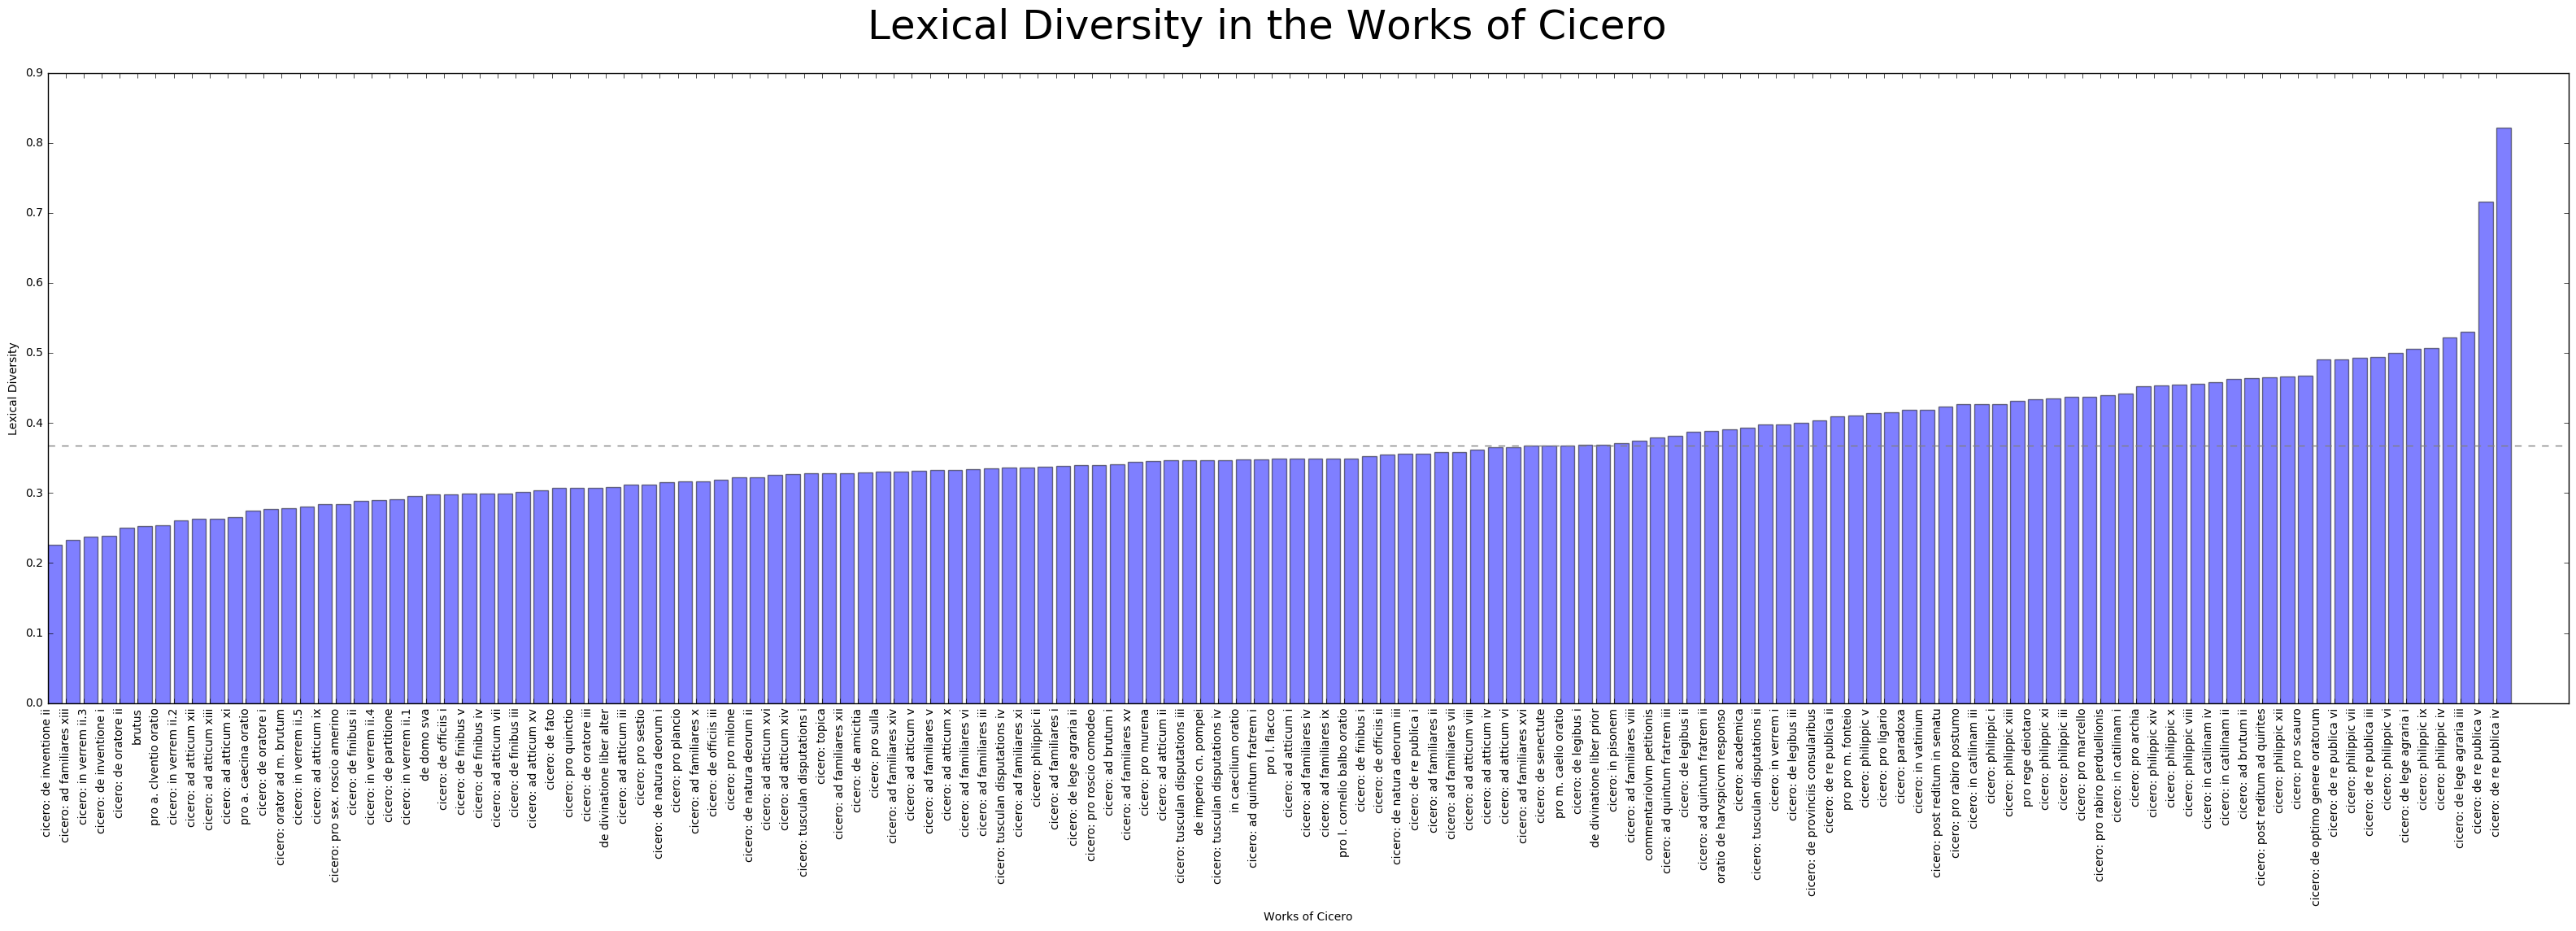

In [68]:
objects = [item[0] for item in lexdivs]
scores = [item[1] for item in lexdivs]
mean = np.mean(scores)

print('Min: ', min(scores))
print('Mean: ', mean)
print('Max: ', max(scores))

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
plt.xticks(y_pos, objects)
plt.axhline(y=mean,color='gray',ls='dashed')
plt.suptitle('Lexical Diversity in the Works of Cicero', fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel('Lexical Diversity')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

<img src="img/poll.png">

Min:  0.22602104803969683
Mean:  0.367160245573
Max:  0.821256038647343


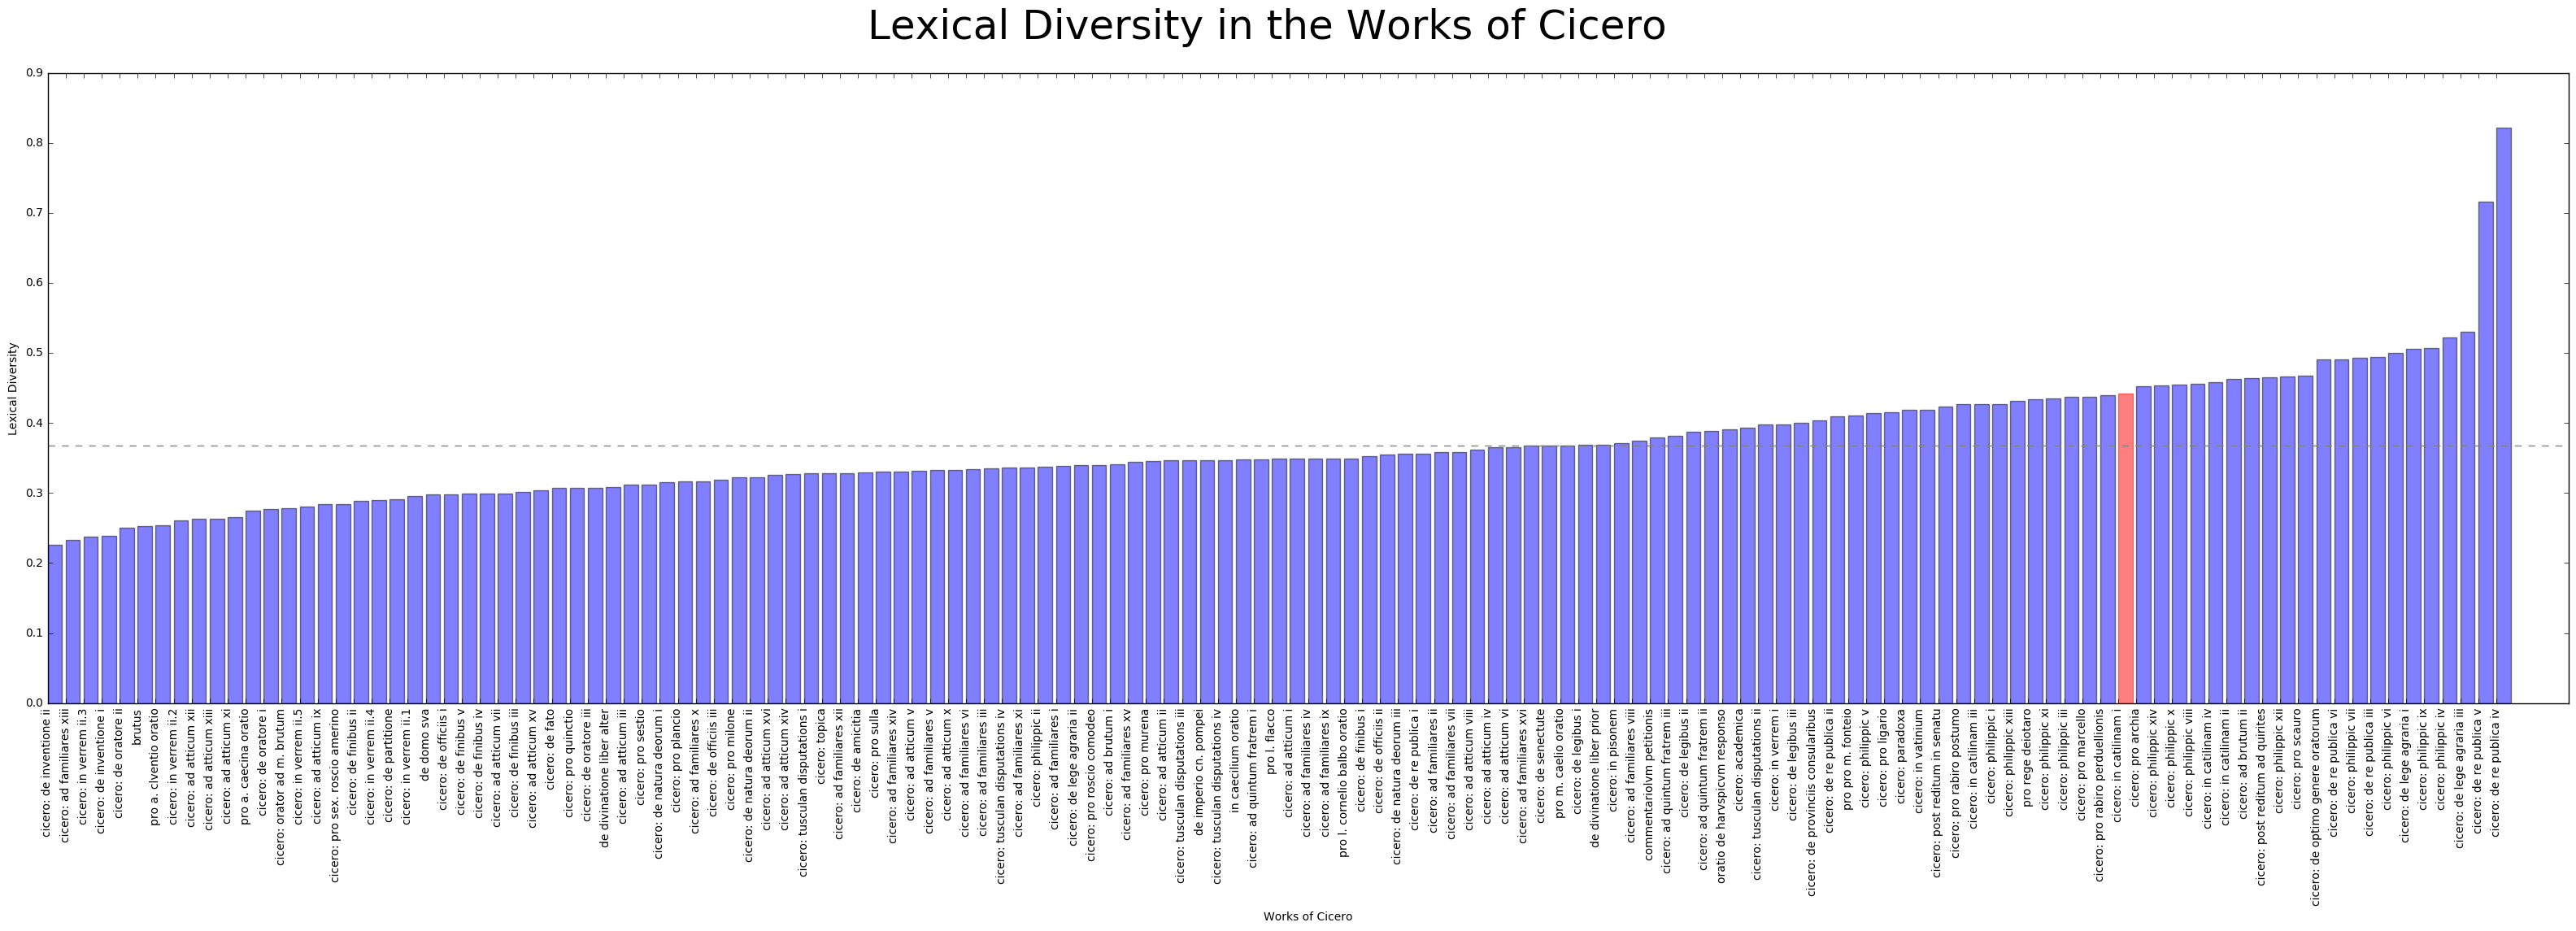

In [69]:
objects = [item[0] for item in lexdivs]
scores = [item[1] for item in lexdivs]
mean = np.mean(scores)

print('Min: ', min(scores))
print('Mean: ', mean)
print('Max: ', max(scores))

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
barlist[objects.index('cicero: in catilinam i')].set_color('r')

plt.xticks(y_pos, objects)
plt.axhline(y=mean,color='gray',ls='dashed')
plt.suptitle('Lexical Diversity in the Works of Cicero', fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel('Lexical Diversity')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

In [27]:
from collections import Counter
c = list(Counter(lexdivs_tokens[0]).items())
#print(c)

print(sum([item[1] for item in c])/len(c))

2.543640897755611


8.518604266068955


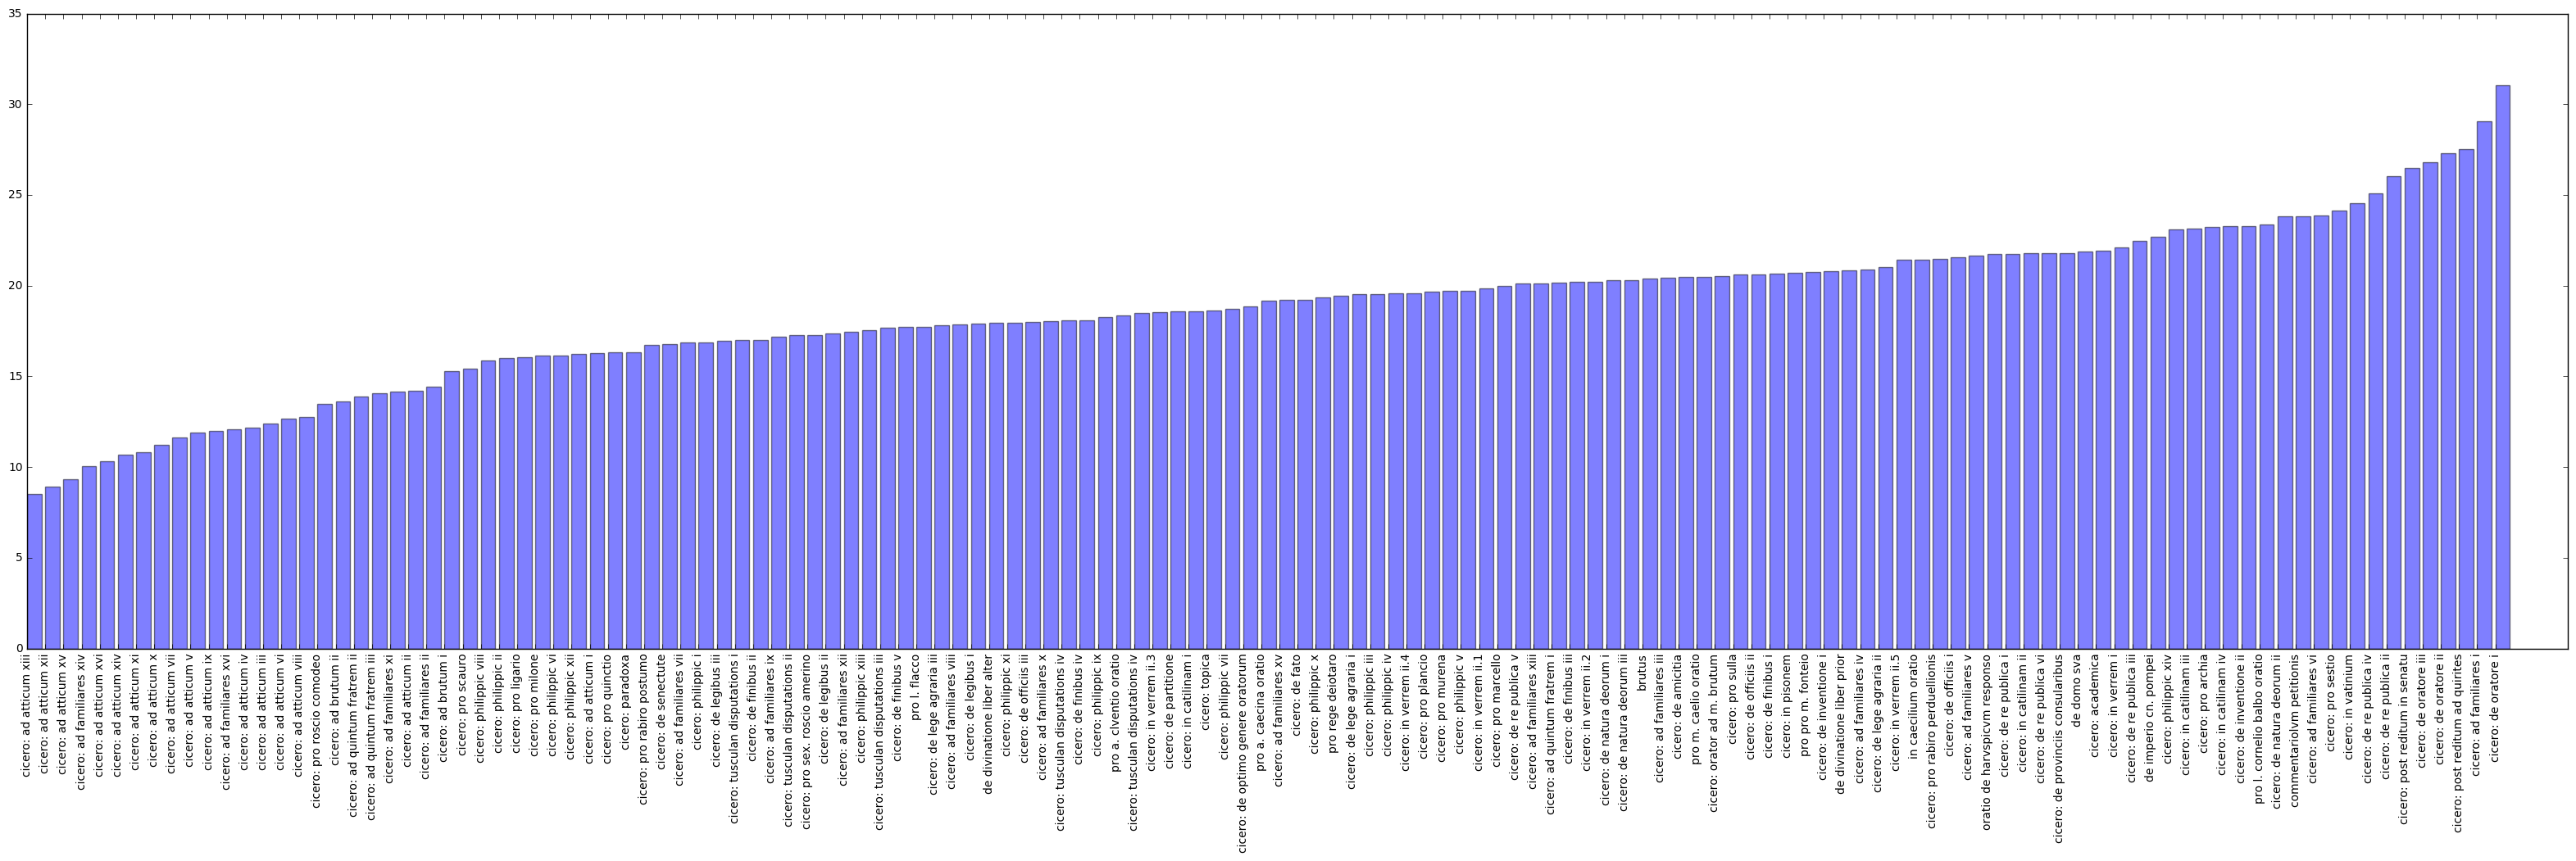

In [28]:
objects = [item[0] for item in aris]
scores = [item[1] for item in aris]


print(min(scores))

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
plt.bar(y_pos, scores, alpha=.5)
plt.xticks(y_pos, objects)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)


plt.show()

In [29]:
cicero_para_flat = [item for para in cicero_paras for item in para]
cicero_sents = [sent_tokenizer.tokenize(item) for item in cicero_para_flat]
cicero_sents_flat = [item for sents in cicero_sents for item in sents]

In [30]:
sent_aris = []

for sent in cicero_sents_flat:
    sent_aris.append((sent, ari(sent)))
    
           
sent_aris.sort(key=lambda x: x[1])
pprint(sent_aris[:5])               
pprint(sent_aris[-5:])



[('.', -18.075), ('.', -18.075), ('.', -18.075), ('.', -18.075), ('.', -18.075)]
[('ego cum mihi cum illo magna iam gratia esset quod eius omnes gravissimas '
  'iniurias communis concordiae causa voluntaria quadam oblivione contriveram '
  'repentinam eius defensionem gabinii quem proximis superioribus diebus '
  'acerrime oppugnasset tamen si sine ulla mea contumelia suscepisset tulissem '
  'sed cum me disputantem non lacessentem laesisset exarsi non solum praesenti '
  'credo iracundia nam ea tam vehemens fortasse non fuisset sed cum inclusum '
  'illud odium multarum eius in me iniuriarum quod ego effudisse me omne '
  'arbitrabar residuum tamen insciente me fuisset omne repente apparuit quo '
  'quidem tempore ipso quidam homines et iidem illi quos saepe nutu '
  'significationeque appello cum se maximum fructum cepisse dicerent ex '
  'libertate mea meque tum denique sibi esse visum rei publicae qualis fuissem '
  'restitutum cumque ea contentio mihi magnum etiam foris fructum t

In [31]:
print(len(sent_aris[-1][0].split()))
print(len(sent_aris[-1][0]))
print(sent_aris[-1])

# Cicero, De Oratore 3.202-205

280
1919
('liii nam et commoratio una in re permultum movet et inlustris explanatio rerumque quasi gerantur sub aspectum paene subiectio quae et in exponenda re plurimum valent et ad inlustrandum id quod exponitur et ad amplificandum ut eis qui audient illud quod augebimus quantum efficere oratio poterit tantum esse videatur et huic contraria saepe percursio est et plus ad intellegendum quam dixeris significatio et distincte concisa brevitas et extenuatio et huic adiuncta inlusio a praeceptis caesaris non abhorrens et ab re digressio in qua cum fuerit delectatio tum reditus ad rem aptus et concinnus esse debebit propositioque quid sis dicturus et ab eo quod est dictum seiunctio et reditus ad propositum et iteratio et rationis apta conclusio tum augendi minuendive causa veritatis supralatio atque traiectio et rogatio atque huic finitima quasi percontatio eitioque sententiae suae tum illa quae maxime quasi inrepit in hominum mentis alia dicentis ac significantis dissimulatio quae est per

In [32]:
lengths = [len(sent.split()) for sent in cicero_sents_flat]

In [33]:
print(max(lengths))

280


In [34]:
print(lengths.index(280))

39550


In [35]:
print(cicero_sents_flat[39550])

liii nam et commoratio una in re permultum movet et inlustris explanatio rerumque quasi gerantur sub aspectum paene subiectio quae et in exponenda re plurimum valent et ad inlustrandum id quod exponitur et ad amplificandum ut eis qui audient illud quod augebimus quantum efficere oratio poterit tantum esse videatur et huic contraria saepe percursio est et plus ad intellegendum quam dixeris significatio et distincte concisa brevitas et extenuatio et huic adiuncta inlusio a praeceptis caesaris non abhorrens et ab re digressio in qua cum fuerit delectatio tum reditus ad rem aptus et concinnus esse debebit propositioque quid sis dicturus et ab eo quod est dictum seiunctio et reditus ad propositum et iteratio et rationis apta conclusio tum augendi minuendive causa veritatis supralatio atque traiectio et rogatio atque huic finitima quasi percontatio eitioque sententiae suae tum illa quae maxime quasi inrepit in hominum mentis alia dicentis ac significantis dissimulatio quae est periucunda cum

In [36]:
print(len(cicero_sents[3198]))

43


## Lexical difficulty

The tests we have looked at so far are all variations on a theme, i.e. they all measure formal features of texts. They all rely on counting characters, words, syllables, and sentences and then processing them algorithmically to determine their readability score. The second feature associated with "classic readability" is lexical difficulty. And for our last exploration of our corpus today, let's look at how the words themselves of a sentence can be used to measure difficulty with the Dale-Chall test.

The Dale-Chall test uses a list of 3,000 "common" words 

In [37]:
import csv
from collections import defaultdict

datapath = 'data/'
datafile = "latin_vocabulary_list.csv"

# Load first column of DCC Core Vocabulary csv file
columns = defaultdict(list)

with open(datapath+datafile) as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        for (i,v) in enumerate(row):
            columns[i].append(v)

dcc_lemmas = columns[0]

# Split headword column by whitespace and keep only first word
dcc_lemmas_simple = [lemma.replace('/',' ').split()[0] for lemma in dcc_lemmas]

In [38]:
# Preprocess DCC lemmas

# Normalize u/v
dcc_lemmas_simple = [replacer.replace(lemma) for lemma in dcc_lemmas_simple]

# remove macrons
def remove_macrons(text):
    transmap = {ord('ā'): 'a', ord('ē'): 'e', ord('ī'): 'i', ord('ō'): 'o', ord('ū'): 'u', }
    return text.translate(transmap)

dcc_lemmas_simple = [remove_macrons(lemma) for lemma in dcc_lemmas_simple]

# Remove punctuation
translator = str.maketrans({key: None for key in string.punctuation})
dcc_lemmas_simple = [lemma.translate(translator) for lemma in dcc_lemmas_simple]

dcc_lemmas_simple.sort()  

In [39]:
print(dcc_lemmas_simple[:25])

['a', 'abeo', 'absum', 'ac', 'accedo', 'accido', 'accipio', 'acer', 'acies', 'ad', 'addo', 'adduco', 'adeo', 'adeo', 'adhibeo', 'adhuc', 'adsum', 'aduenio', 'aduersus', 'aduersus', 'aduerto', 'aedes', 'aeger', 'aegre', 'aeque']


In [40]:
# Postprocess lemmas
def postprocess_lemmas(lemmas):
    translator = str.maketrans({key: "" for key in '0123456789'})
    lemmas = [lemma.translate(translator) for lemma in lemmas]
    lemmas = [replacer.replace(lemma) for lemma in lemmas]
    return lemmas

In [41]:
def difficult_words(text):
    tokens = word_tokenizer.tokenize(text)
    lemmas = lemmatizer.lemmatize(tokens)
    lemmas = [lemma[1] for lemma in lemmas if lemma[1] != 'punc']
    lemmas = postprocess_lemmas(lemmas)
    difficult_words = [lemma for lemma in lemmas if lemma not in dcc_lemmas_simple]
    #print(difficult_words)
    return len(difficult_words)

In [42]:
def dalechall(text):
    w, s, dw = word_count(text), sent_count(text), difficult_words(text)
    return (0.1579 * ((dw / w) * 100)) + (0.0496 * (w / s))

In [46]:
dcs = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    dcs.append((cicero_titles[i],dalechall(text)))
              
dcs.sort(key=lambda x: x[1])
pprint(dcs[:5])               
pprint(dcs[-5:])

[('cicero: ad atticum xi', 3.7046828106999192),
 ('cicero: pro ligario', 3.9010221559236875),
 ('cicero: de finibus ii', 3.96579106468621),
 ('cicero: ad brutum ii', 3.9918146497198164),
 ('cicero: ad atticum iii', 4.092461738291885)]
[('cicero: de re publica ii', 5.812602760481245),
 ('cicero: de re publica iv', 5.814713871635611),
 ('cicero: de natura deorum ii', 5.817898694916808),
 ('cicero: de oratore i', 5.873284890271979),
 ('de divinatione liber prior', 5.941131199346778)]


In [61]:
objects = [item[0] for item in dcs]
print(objects.index('cicero: in catilinam i'))

37


Min:  3.7046828106999192
Mean:  4.80012685509
Max:  5.941131199346778


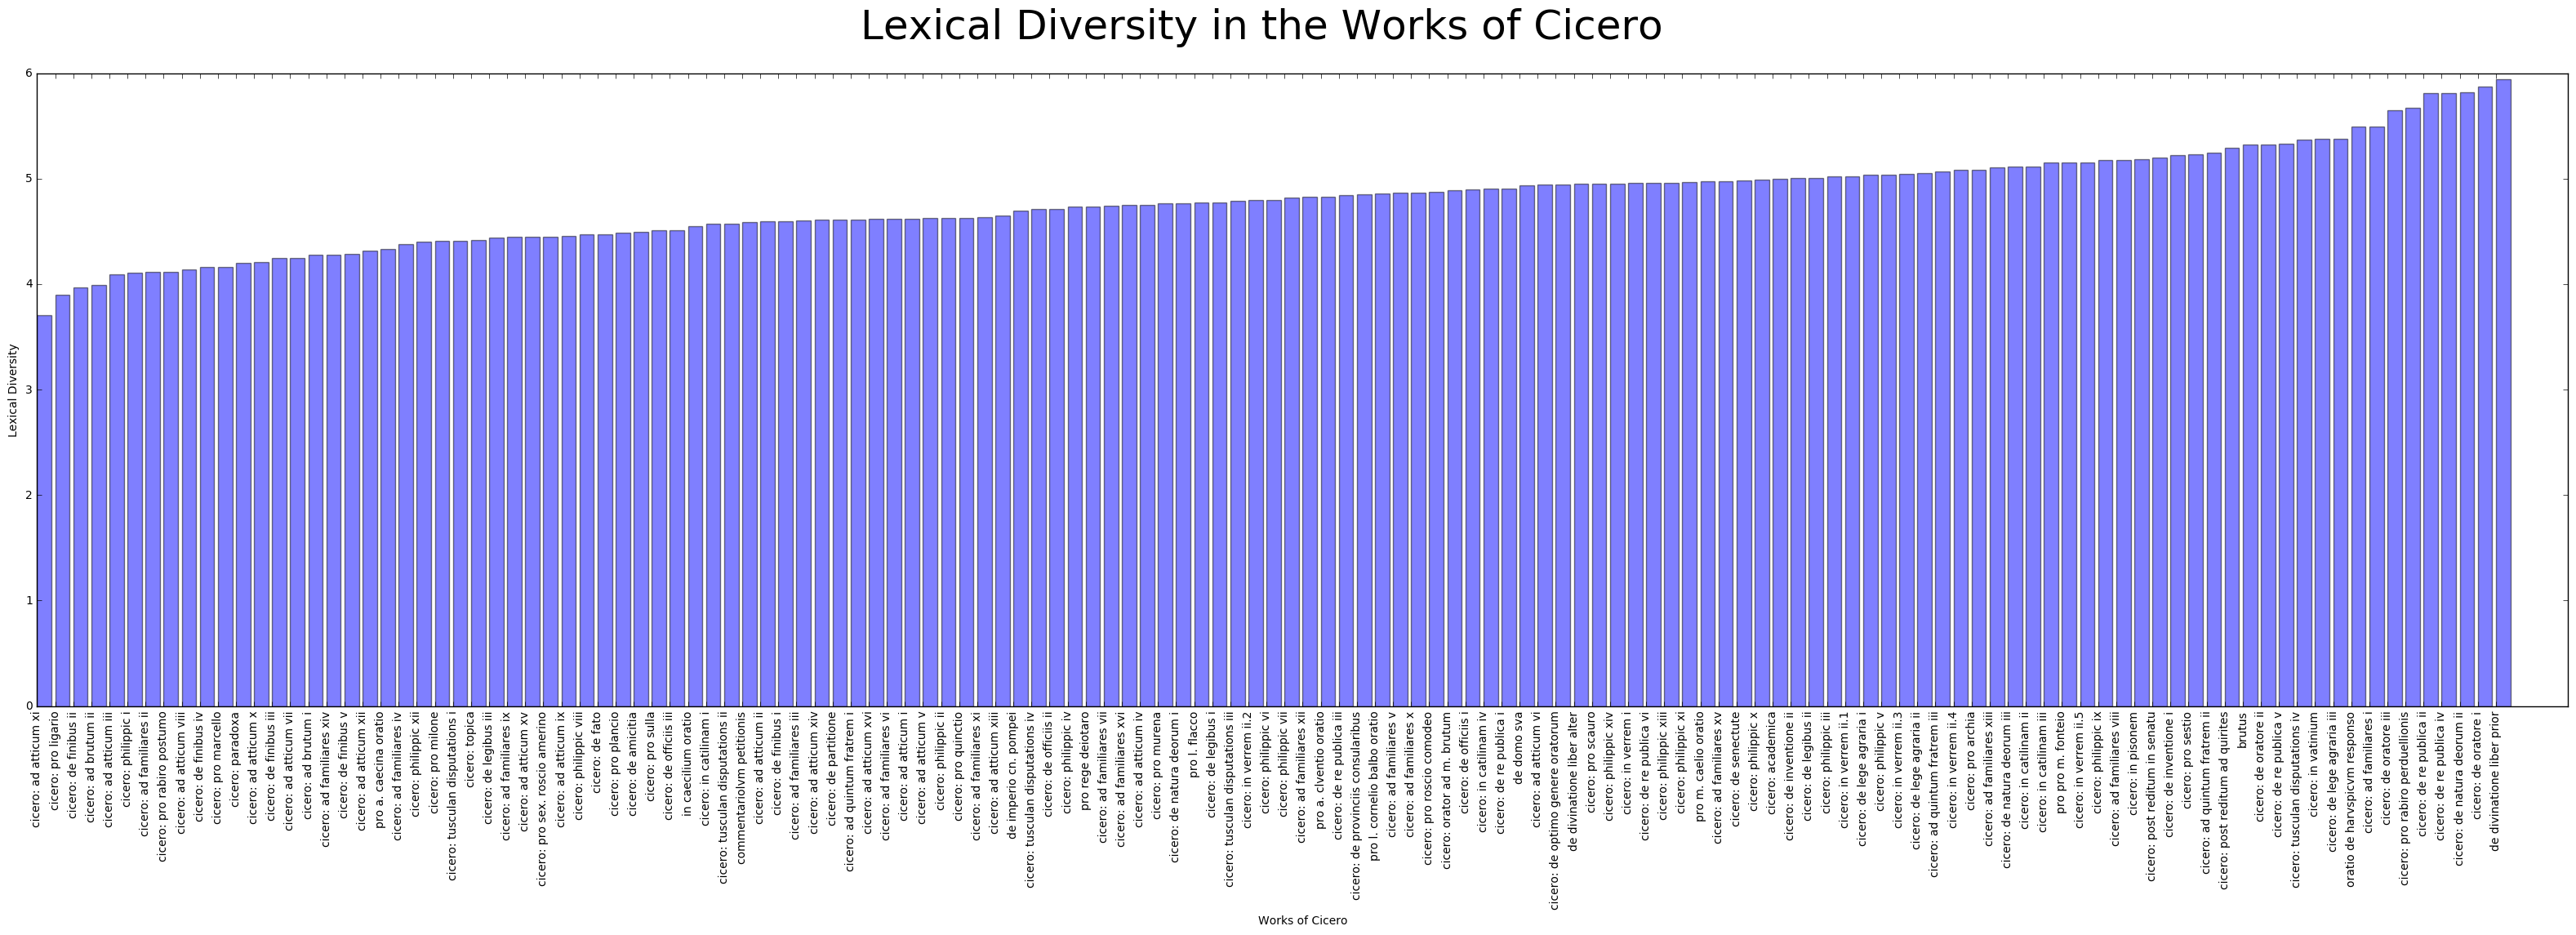

In [64]:
objects = [item[0] for item in dcs]
scores = [item[1] for item in dcs]

print('Min: ', min(scores))
print('Mean: ', np.mean(scores))
print('Max: ', max(scores))

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
plt.xticks(y_pos, objects)
plt.suptitle('Lexical Diversity in the Works of Cicero', fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel('Lexical Diversity')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

Min:  3.7046828106999192
Mean:  4.80012685509
Max:  5.941131199346778


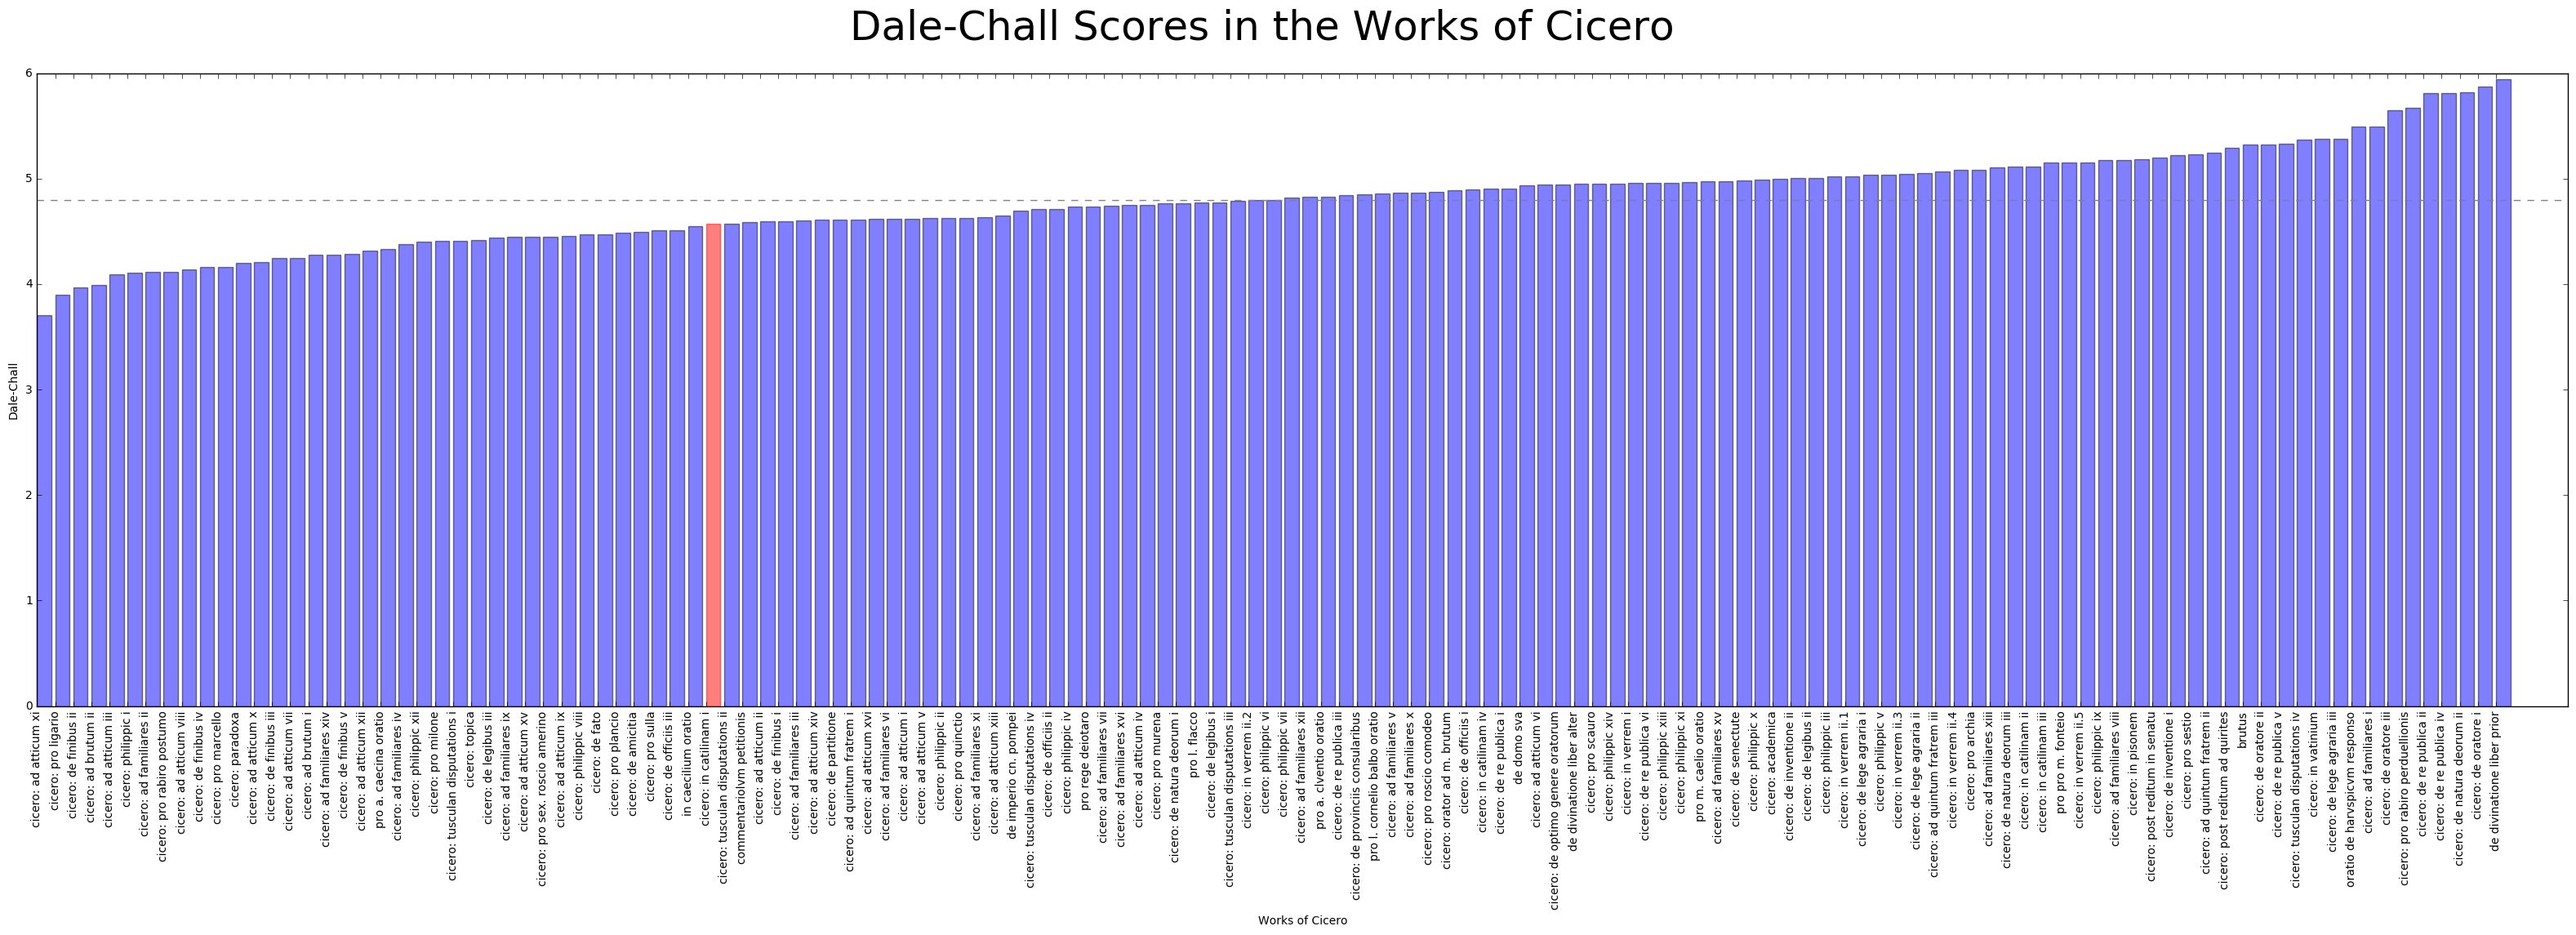

In [67]:
objects = [item[0] for item in dcs]
scores = [item[1] for item in dcs]
mean = np.mean(scores)


print('Min: ', min(scores))
print('Mean: ', mean)
print('Max: ', max(scores))

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
barlist[objects.index('cicero: in catilinam i')].set_color('r')
plt.xticks(y_pos, objects)
plt.axhline(y=mean,color='gray',ls='dashed')
plt.suptitle('Dale-Chall Scores in the Works of Cicero', fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel('Dale-Chall')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

## Challenges with historical languages

Latin, classical Greek, and other historical languages present unique challenges when approaching readability. The two main difficulties are:

- Fewer expert readers (and no native readers); much of the literature on English readability is built upon the assumptions that:
    - 1. children develop a working vocabulary naturally over the course of many years, primarily without the assistance of formal education
    - 2. children develop (again with formal education) an ability to form on the one hand and recognize on the other sentences of increasing complexity
    - 3. children are surrounded by adult expert users of the language to offer a model and source of continuous, often informal correction
- All Latin words are learned in formal educational contexts; cf. the 3,000 D-C wordlist
- Compressed time line for developing "proficiency," also in formal educational contexts
- Much less standardized testing data for comparison and cross-validation

## Next Steps

Some ideas of where to go next with readability studies for Latin/Greek:
- Identification / development of "criterion passages"
    - i.e. passages rated on an "independent measure such as a test of reading comprehension, rate of reading, or judgments of difficulty.
- Improved, expanded word lists
- Increase attention to the role of the other primary domains of readability studies: the reader and the context.

## Conclusion

"It should be remembered that readability formulas estimate difficulty on the basis of factors that have the highest prediction of difficulty. ...No readability formula is a complete and full measure of text difficulty." Chall & Dale 1995, 5-6

Notes:
- Zipf and decreasing word length
- Talk about subjective measures, inc. student reading time (cf. Medium's "minutes" feature)
- If we think in terms of Vygotsky's "proximal" zone of development we can use these measurements to find texts that are just a bit more challenging than where students are, but not so difficult that they are fully discouraging.
